# Intro

本文解析c2w和w2c矩阵，并可视化c2w矩阵。我们遵循常见的约定：相机坐标下的相机在原点，并且相机坐标轴由$\vec{\mathbf{x}},\vec{\mathbf{y}},\vec{\mathbf{z}}$三个轴定义，其中$\vec{\mathbf{z}}$与相机面向的方向相反，$\vec{\mathbf{y}}$为相机向上的方向，$\vec{\mathbf{x}}=-\vec{\mathbf{z}}\times \vec{\mathbf{y}}$（右手定则）。

*不同的渲染方式规定了不同的的相机坐标轴，比如rasterization-based rendering普遍遵守上面的约定，而volume rendering普遍约定$\vec{\mathbf{z}}$轴与相机朝向相同，而$\vec{\mathbf{y}}$轴指向相机朝下的方向，如下图。

<img src="../pasteImage/world_camera_coordinate.png"/>

# 3D几何旋转与矩阵

齐次坐标下旋转矩阵表示为
$$
\begin{equation}
\begin{pmatrix}
| & | & | & |\\
\vec{\mathbf{x}} & \vec{\mathbf{y}} & \vec{\mathbf{z}} & \vec{\mathbf{t}}\\
| & | & | & |\\
0 & 0 & 0 & 1\\
\end{pmatrix}=
\begin{pmatrix}
1 & 0 & 0 & |\\
0 & 1 & 0 & \vec{\mathbf{t}}\\
0 & 0 & 1 & |\\
0 & 0 & 0 & 1\\
\end{pmatrix}
\begin{pmatrix}
| & | & | & 0\\
\vec{\mathbf{x}} & \vec{\mathbf{y}} & \vec{\mathbf{z}} & 0\\
| & | & | & 0\\
0 & 0 & 0 & 1\\
\end{pmatrix}
\end{equation}
$$
其中$\vec{\mathbf{x}},\vec{\mathbf{y}},\vec{\mathbf{z}}$两两正交，$t$为平移向量。

旋转平移矩阵的逆等效于旋转平移的逆操作。


# c2w矩阵含义和w2c矩阵的转换

**约定**：相机坐标下的相机位置永远在原点，并且相机坐标轴由$\vec{\mathbf{x}},\vec{\mathbf{y}},\vec{\mathbf{z}}$三个轴定义，其中$\vec{\mathbf{z}}$与相机面向的方向相反，$\vec{\mathbf{y}}$为相机向上的方向，$\vec{\mathbf{x}}=-\vec{\mathbf{z}}\times \vec{\mathbf{y}}$（右手定则）。

给定世界坐标下的相机坐标$\mathbf{c}=(c_x,c_y,c_z)$，我们想要求得世界坐标$\mathbf{x}_w$的相机坐标$\mathbf{x}_c=(a,b,d)^T$。我们有：
$$
a\vec{\mathbf{x}}+b\vec{\mathbf{y}}+d\vec{\mathbf{z}}+\mathbf{c}=\mathbf{x}_w
$$
上式等效于
$$
\begin{equation}
\begin{pmatrix}
| & | & | & |\\
\vec{\mathbf{x}} & \vec{\mathbf{y}} & \vec{\mathbf{z}} & \mathbf{c}\\
| & | & | & |\\
0 & 0 & 0 & 1\\
\end{pmatrix}
\mathbf{x}_c=\mathbf{x}_w
\end{equation}
$$
那么我们获得了相机坐标向世界坐标转化的矩阵$\mathbf{R}_{c2w}$：
$$
\begin{equation}
\mathbf{R}_{c2w}=
\begin{pmatrix}
| & | & | & |\\
\vec{\mathbf{x}} & \vec{\mathbf{y}} & \vec{\mathbf{z}} & \mathbf{c}\\
| & | & | & |\\
0 & 0 & 0 & 1\\
\end{pmatrix}=
\underbrace{\begin{pmatrix}
1 & 0 & 0 & |\\
0 & 1 & 0 & \mathbf{c}\\
0 & 0 & 1 & |\\
0 & 0 & 0 & 1\\
\end{pmatrix}}_\mathrm{translation}
\underbrace{\begin{pmatrix}
| & | & | & 0\\
\vec{\mathbf{x}} & \vec{\mathbf{y}} & \vec{\mathbf{z}} & 0\\
| & | & | & 0\\
0 & 0 & 0 & 1\\
\end{pmatrix}}_\mathrm{rotation}
\end{equation}
$$
> 可以这样理解c2w矩阵：
> - 一开始的相机坐标系和世界坐标重合
> - 将相机坐标系按照$\mathrm{rotation}$矩阵旋转
> - 再将相机坐标系按照$\mathrm{translation}$矩阵平移

因为旋转矩阵的逆表示逆向操作，我们可以获得世界坐标到相机坐标的转换$\mathbf{R}_{w2c}$
$$
\mathbf{R}_{w2c}=\mathbf{R}_{c2w}^{-1}
$$
本矩阵在raterization-based rendering中常被用作将3D坐标转化到相机坐标。


# c2w/w2c矩阵的生成

要求：相机坐标落在在半径为$R$的球面上，相机永远面向世界坐标原点。

主要的难点在于如何使得生成的c2w/w2c矩阵的z轴与相机面向的方向相反？

上面我们分析了c2w矩阵可以分解为旋转平移两部分，此处不妨将c2w的生成分解为两部分：

- 一开始的相机坐标系和世界坐标重合
- 将相机坐标系沿着世界坐标的z轴平移$R$距离
- 再将相机坐标系绕世界坐标的原点旋转

如下图所示，可以保证这样生成的相机坐标系的z轴永远与相机面向的方向相反。

<img src="../pasteImage/generate_c2w.png"/>


In [1]:
import torch
import numpy as np

cam_radius = 3

@torch.no_grad()
def random_rotation_translation(t, device=None):
    m = np.random.normal(size=[3, 3])
    m[1] = np.cross(m[0], m[2])
    m[2] = np.cross(m[0], m[1])
    m = m / np.linalg.norm(m, axis=1, keepdims=True)
    m = np.pad(m, [[0, 1], [0, 1]], mode='constant')
    m[3, 3] = 1.0
    m[:3, 3] = np.random.uniform(-t, t, size=[3])
    return torch.tensor(m, dtype=torch.float32, device=device)

def translate(x, y, z, device=None):
    return torch.tensor([[1, 0, 0, x], 
                         [0, 1, 0, y], 
                         [0, 0, 1, z], 
                         [0, 0, 0, 1]], dtype=torch.float32, device=device)

mv = translate(0, 0, -cam_radius) @ random_rotation_translation(0) # w2c (4,4)
pose = torch.linalg.inv(mv) # c2w (4,4)

/home/xingyu/anaconda3/envs/testbed/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor(3.0000) tensor([0.3333, 0.3333, 0.3333])


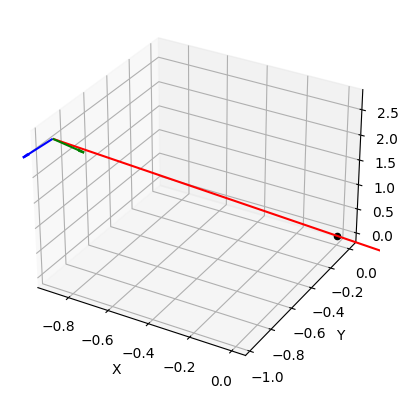

In [3]:
import matplotlib.pyplot as plt

def safe_normalize(x, eps=1e-20):
    return x / torch.sqrt(torch.clamp(torch.sum(x * x, -1, keepdim=True), min=eps))

def visual_c2w(c2w):
    x, y, z, c = safe_normalize(c2w[:3, 0])*0.2, safe_normalize(c2w[:3, 1])*0.2, safe_normalize(c2w[:3, 2]), c2w[:3, 3]
    print(torch.sum(z * c), z/c)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    z = torch.sum(c * c, -1, keepdim=True) * z
    ax.scatter(0, 0, 0, c='k', marker='o')
    ax.quiver(c[0], c[1], c[2],
                x[0], x[1], x[2],
                color="b",
                arrow_length_ratio=0.2)
    ax.quiver(c[0], c[1], c[2],
                y[0], y[1], y[2],
                color="g", arrow_length_ratio=0.2)
    ax.quiver(c[0], c[1], c[2],
                -z[0], -z[1], -z[2],
                color="r", arrow_length_ratio=0.2)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

visual_c2w(pose)